### Tutorial pedestrian detection using HOGMAP

In [1]:
#Pkg.update()
#using PyPlot
using TestImages
using ImageFeatures
using Images
using TestImages
using ImageDraw
using ImageDraw 
#using Perceptron
using BenchmarkTools

In [2]:
#using Pkg
#Pkg.clone("https://github.com/davidbp/Perceptron.jl")

In [3]:
## Param for the notebook
stride = 10

10

### About hog
- https://github.com/JuliaImages/ImageFeatures.jl/blob/master/docs/src/tutorials/object_detection.md

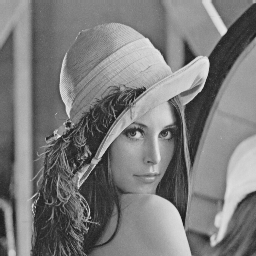

In [4]:
img = testimage("lena_gray")

#### AMDALS law

The hogmap part of this tutorial takes a small fraction of the time.

Most of the time is spend in the computation of `magnitudes` and `angles`.

In [5]:
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"
#path_positive_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians128x64/"
#path_negative_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians_neg/"

pos_example_names = readdir(path_positive_examples)
neg_example_names = readdir(path_negative_examples)
pos_images = []
neg_images = []

for n in pos_example_names
    push!(pos_images, load( path_positive_examples * n))
end

for n in neg_example_names
    push!(neg_images, load( path_negative_examples * n))
end

### <font color='red'> CHANGE 1 Computing angles and magnitudes faster </font>

A preprocess for computing the HOG consist on computing the gradient of the image in polar form. That is, computing the `angles` and `magnitudues` arrays.



Currently we do the following:


<font color='red'>  Think about simd vectors for doing this </font>

In [6]:
kernel_x = centered([-1 0 1])
kernel_y = centered([-1 0 1]')

@benchmark begin
    gx          = imfilter(img, kernel_x)
    gy          = imfilter(img, kernel_y);
    magnitudes  = hypot.(gx, gy);
    angles      = abs.(orientation.(gy, gx));
end

BenchmarkTools.Trial: 
  memory estimate:  12.15 MiB
  allocs estimate:  1099
  --------------
  minimum time:     7.653 ms (0.00% GC)
  median time:      15.888 ms (0.00% GC)
  mean time:        17.020 ms (0.00% GC)
  maximum time:     49.381 ms (0.00% GC)
  --------------
  samples:          294
  evals/sample:     1

In [7]:
kernel_x = (ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1])),)
kernel_y = (ImageFiltering.ReshapedOneD{2,0}(centered([-1,0,1])),)

@benchmark begin
    gx          = imfilter(img, kernel_x)
    gy          = imfilter(img, kernel_y);
    magnitudes  = hypot.(gx, gy);
    angles      = abs.(orientation.(gy, gx));
end

BenchmarkTools.Trial: 
  memory estimate:  1.51 MiB
  allocs estimate:  56
  --------------
  minimum time:     2.285 ms (0.00% GC)
  median time:      3.328 ms (0.00% GC)
  mean time:        3.406 ms (0.00% GC)
  maximum time:     45.174 ms (0.00% GC)
  --------------
  samples:          1463
  evals/sample:     1

Let us verify that the `gx` and `gy` are actually equivalent

In [8]:
kernel_x = centered([-1 0 1])
kernel_y = centered([-1 0 1]')
gx_1          = imfilter(img, kernel_x)
gy_1          = imfilter(img, kernel_y)

kernel_x = (ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1])),)
kernel_y = (ImageFiltering.ReshapedOneD{2,0}(centered([-1,0,1])),)

gx_2          = imfilter(img, kernel_x)
gy_2          = imfilter(img, kernel_y)

# Verifyes if they are the same
isapprox(gx_1, gx_2), isapprox(gy_1, gy_2)

(true, true)

#### Computing angles and magnitudes without allocations 

We can compute magnitudes and angles in a for loop

In [27]:
gx          = imfilter(img, kernel_x);
gy          = imfilter(img, kernel_y);
magnitudes  = zeros(size(gx))
angles      = zeros(size(gx))
@benchmark begin
    magnitudes  .= hypot.(gx, gy);
    angles      .= abs.(orientation.(gy, gx));
end

BenchmarkTools.Trial: 
  memory estimate:  128 bytes
  allocs estimate:  6
  --------------
  minimum time:     91.717 μs (0.00% GC)
  median time:      98.239 μs (0.00% GC)
  mean time:        103.766 μs (0.00% GC)
  maximum time:     543.937 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

We could change it to:

In [28]:
function magnitudes_and_angles!(magnitudes, angles, gx, gy)
   
    @inbounds for i in 1:length(gx)
        magnitudes[i] = hypot(gx[i], gy[i])
        angles[i]     = abs(orientation(gy[i], gx[i]))
    end
end

magnitudes_and_angles! (generic function with 1 method)

In [29]:
@benchmark magnitudes_and_angles!(magnitudes, angles, gx, gy)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     76.233 μs (0.00% GC)
  median time:      80.907 μs (0.00% GC)
  mean time:        83.209 μs (0.00% GC)
  maximum time:     348.797 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

### <font color='red'> CHANGE 2 Computing angles and magnitudes inplace </font>


Currently `imfilter` allocates memory at every call. If we would like to use this in real time fashion we would need something that has less variance in  performance. The less allocations we need the less GC time is spend and the lower the maximum time we will see in the benchmarks.

In [12]:
gx         = zeros(256, 256);
gy         = zeros(256, 256);
magnitudes = zeros(256, 256);
angles     = zeros(256, 256);

In [13]:
kernel_x = (ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1])),)
kernel_y = (ImageFiltering.ReshapedOneD{2,0}(centered([-1,0,1])),)

@benchmark begin
    imfilter!(gx, img, kernel_x)
    imfilter!(gy, img, kernel_y);
    magnitudes  = hypot.(gx, gy);
    angles      = abs.(orientation.(gy, gx));
end

BenchmarkTools.Trial: 
  memory estimate:  2.02 MiB
  allocs estimate:  52
  --------------
  minimum time:     3.140 ms (0.00% GC)
  median time:      4.237 ms (0.00% GC)
  mean time:        4.391 ms (0.00% GC)
  maximum time:     27.999 ms (0.00% GC)
  --------------
  samples:          1136
  evals/sample:     1

In [14]:
# why is this soooo slow???
@benchmark angles      = abs.(orientation.(gy, gx))

BenchmarkTools.Trial: 
  memory estimate:  512.16 KiB
  allocs estimate:  6
  --------------
  minimum time:     2.101 ms (0.00% GC)
  median time:      2.417 ms (0.00% GC)
  mean time:        2.443 ms (0.00% GC)
  maximum time:     9.723 ms (0.00% GC)
  --------------
  samples:          2040
  evals/sample:     1

In [15]:
@benchmark angles      = orientation.(gy, gx)

BenchmarkTools.Trial: 
  memory estimate:  512.13 KiB
  allocs estimate:  4
  --------------
  minimum time:     2.100 ms (0.00% GC)
  median time:      2.423 ms (0.00% GC)
  mean time:        2.461 ms (0.00% GC)
  maximum time:     3.829 ms (0.00% GC)
  --------------
  samples:          2024
  evals/sample:     1

In [16]:
#@benchmark angles      =  atan2.(gy, gx)

In [17]:
kernel_x = (ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1])),)
kernel_y = (ImageFiltering.ReshapedOneD{2,0}(centered([-1,0,1])),)

@benchmark begin
    imfilter!(gx, img, kernel_x)
    imfilter!(gy, img, kernel_y);
    magnitudes  = hypot.(gx, gy);
    #angles      = abs.(orientation.(gy, gx));
end

BenchmarkTools.Trial: 
  memory estimate:  1.52 MiB
  allocs estimate:  46
  --------------
  minimum time:     1.503 ms (0.00% GC)
  median time:      1.714 ms (0.00% GC)
  mean time:        1.891 ms (0.00% GC)
  maximum time:     125.829 ms (0.00% GC)
  --------------
  samples:          2638
  evals/sample:     1

Notice that we are still allocating 1 Mb and we don't get faster performance

Actually we went from

- `median time 3.199 ms (5.08% GC)` using `imfilter`

to

-  `median time: 4.156 ms (0.00% GC)` using `imfilter!`


How is this even possible?

In [18]:
kernel_x = (ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1])),)
@benchmark  imfilter(img, kernel_x)

BenchmarkTools.Trial: 
  memory estimate:  519.23 KiB
  allocs estimate:  23
  --------------
  minimum time:     222.524 μs (0.00% GC)
  median time:      511.863 μs (0.00% GC)
  mean time:        644.290 μs (9.96% GC)
  maximum time:     540.848 ms (99.90% GC)
  --------------
  samples:          8419
  evals/sample:     1

In [19]:
kernel_x   = (ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1])),)
gx         = zeros(256, 256);
@benchmark  imfilter!(gx, img, kernel_x)

BenchmarkTools.Trial: 
  memory estimate:  521.16 KiB
  allocs estimate:  21
  --------------
  minimum time:     210.839 μs (0.00% GC)
  median time:      465.784 μs (0.00% GC)
  mean time:        521.095 μs (8.71% GC)
  maximum time:     431.921 ms (99.87% GC)
  --------------
  samples:          9506
  evals/sample:     1

#### <font color='red'> CORRECT THE FOLLOWING </font>
**<font color='red'> It turns out `imfilter!` is not faster and it does not allocate less memory than `imfilter`. </font>**





## HOG descriptor

- https://github.com/JuliaImages/ImageFeatures.jl/blob/master/docs/src/tutorials/object_detection.md

In [20]:
typeof(img), size(img)

(Array{Gray{Normed{UInt8,8}},2}, (256, 256))

In [21]:
using ImageFeatures

h = HOG(orientations=9,
        cell_size=8,
        block_size = 2,
        block_stride = 1,
        norm_method="L2-norm")

HOG(9, 8, 2, 1, "L2-norm")

In [22]:
@time hog_features = create_descriptor(pos_images[1], h);

  6.143903 seconds (15.56 M allocations: 770.400 MiB)


In [23]:
@time hog_features = create_descriptor(pos_images[1], h);

  0.010041 seconds (9.64 k allocations: 12.887 MiB)


In [24]:
size(img), size(hog_features)

((256, 256), (3780,))

### Load pedestrian data

In [25]:
#path_positive_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians128x64/"
#path_negative_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians_neg/"
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"

pos_example_names = readdir(path_positive_examples)
neg_example_names = readdir(path_negative_examples)

n_pos = length(pos_example_names)
n_neg = length(neg_example_names)

n      = n_pos + n_neg              # number of training examples 
data   = zeros(Float64, 3780, n)    # Array to store HOG descriptor of each image. Each image in our training data has size 128x64 and so has a 3780 length 
labels = Vector(zeros(Int64, n));   # Vector to store label (1=human, 0=not human) of each image.


for (i, file) in enumerate([pos_example_names ; neg_example_names])

    # filename = "$(i <= n_pos ? path_positive_examples : path_negative_examples)/$file"
    if i <= n_pos
        filename =  path_positive_examples * file
    else
        filename = path_negative_examples * file
    end
    
    img = load(filename)   
    if i > n_pos # negative samples are bigger, we take a patch of the same shape
        img = img[1:128, 1:64]
    end
    
    data[:, i] = create_descriptor(img, HOG())
    labels[i] = (i <= n_pos ? 1 : 0)
end

In [26]:
println("size of the data:             ", size(data))
println("size of the labels:           ", size(labels))
println("number of negative labels:    ", sum(labels.==0))
println("number of positive labels:    ", sum(labels.==1))

size of the data:             (3780, 974)
size of the labels:           (974,)
number of negative labels:    50
number of positive labels:    924


### Generate negative samples of shape (128,64)

In [30]:
function extract_patches_2d(image, patch_size, stride)
    
    n_rows, n_cols = size(image) 
    n_rows_patch, n_cols_patch = patch_size
    patches = []
    for i in 1:stride:(n_rows - n_rows_patch)
        for j in 1:stride:(n_cols - n_cols_patch)
            push!(patches, image[i:i+n_rows_patch-1, j:j+n_cols_patch-1])
        end
    end
    
    return patches
end


extract_patches_2d (generic function with 1 method)

In [31]:
negative_patches = extract_patches_2d(neg_images[1], (128,64), 10);

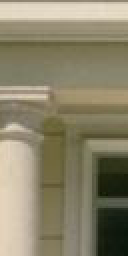

In [32]:
negative_patches[2]

In [33]:
hog_features = create_descriptor(negative_patches[1], h);
size(hog_features)

(3780,)

## Custom Hog descriptor

In [34]:
function to_gray(image)
    x = Array{ColorTypes.Gray{Float32}, 2}(image)
    return Array{Float32}(x)
end

function to_grayscale(image)
    return Array{ColorTypes.Gray{Float32}, 2}(image)
end

to_grayscale (generic function with 1 method)

### Time required for the gradient computation

In order to know if we can do the HOG in a real time way we need to check that the required step of the gradient image is fast enough.

In [35]:
img = load("tutorial/humans.jpg")
img_gray = to_gray(img);

In [36]:
@btime begin
    kernel_x = (ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1])),)
    kernel_y = (ImageFiltering.ReshapedOneD{2,0}(centered([-1,0,1])),)

    gx          = imfilter(img_gray, kernel_x)
    gy          = imfilter(img_gray, kernel_y);
    magnitudes  = hypot.(gx, gy);
    angles      = abs.(orientation.(gy, gx));
end;

  6.745 ms (64 allocations: 3.98 MiB)


In [37]:
@btime begin
    #gx          = imfilter(img, kernel_x)
    #gy          = imfilter(img, kernel_y);
    gx          = imfilter(img_gray, centered([-1 0 1]))
    gy          = imfilter(img_gray, centered([-1 0 1]'));

    magnitudes  = hypot.(gx, gy);
    angles      = abs.(orientation.(gy, gx));
end;

  15.967 ms (2048 allocations: 14.66 MiB)


In [38]:
size(img_gray)

(342, 505)

#### Summarizing the detection process

- (1) - Gradient computation
- (2) - HogMap computation
- (3) - Model Detection

In an image of Float32, `(342, 505)`, it takes 7.01 ms to compute the magnitudes and angles (0.007 sec). Notice that this means the total time needed to do this 50 times is `0.35 sec = 0.007 ms * 50`.

Notice that `1 sec = 1000 ms` and `1000/50 ms = 20 ms`. Which means that If we want to do the pedestrian detection at `50 fps` we need to do the whole process of (1), (2) and (3) to take at most `20 ms` (or `0.02 sec`).

So far we know we need 0.007 sec to compute the gradients in the image. If `0.02` is the total time for the detection process we are spending a `35%` of the time to compute the gradient 

percentage_of_gradient_time =  `35% = 100*(0.007/0.02)`



## From gradient image to histogram map (Hog Map)

Now that we have benchmarked we need `0.007 sec`  (`35%` of `0.02` seconds) to compute the gradient of an image we know we have `0.002 - 0.007 = 0.1993 sec` to do the rest of the work.

The rest of the work involves 

- (2) - Summarize regions of the image in a grid of histograms of oriented gradients. This process is done applying a `gradients_to_bins` function to every subset of an image.  This function  takes as input a subset of the `magnitudes` and `orientations` and builds a histogram for that subset. The function is applied to all positions of an image using `histogram_map`.


- (3) - Apply a model to subsets of the `hogmap` in order to detect if a person is present or not.



###  `gradients_to_bins` with boundaries computed at runtime


In [39]:
"""
Simple version
- This is not block normalized
- This does not take into account distance between the limits of the bin and the final chosen bin
"""
function gradients_to_bins!(hist, magnitudes, orientations)
    n_bins = length(hist)
    T = eltype(magnitudes)
    bin_width = T(pi/n_bins)
    
    @inbounds for (orientation, magnitude) in zip(orientations, magnitudes)
        local upper_bin_limit = bin_width
        for i in 1:n_bins
            if  orientation <= upper_bin_limit
                hist[i] += magnitude
                break
            end
            upper_bin_limit += bin_width
        end
    end
end


gradients_to_bins!

In [40]:
n_bins = 9
hist   = zeros(n_bins)

kernel_x    = (ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1])),)
kernel_y    = (ImageFiltering.ReshapedOneD{2,0}(centered([-1,0,1])),)
gx          = imfilter(img_gray, kernel_x)
gy          = imfilter(img_gray, kernel_y);
magnitudes  = hypot.(gx, gy);
angles      = abs.(orientation.(gy, gx));

magnitudes_small = magnitudes[1:16,1:16]
angles_small    = angles[1:16,1:16];

@btime gradients_to_bins!(hist, $magnitudes_small, $angles_small)

  818.679 ns (0 allocations: 0 bytes)


In [41]:
function histogram_map(magnitudes, angles, cell_stride, cell_size, n_bins)
    n_rows, n_cols   = size(magnitudes)
    n_rows_out       = Int(floor((n_rows - cell_size)/cell_stride)) ## Look here how to get CORRECT VALUE
    n_cols_out       = Int(floor((n_cols - cell_size)/cell_stride)) 
    output_histogram = zeros(n_rows_out, n_cols_out, n_bins)

    # for each position in the output_histogram
    # compute the hog in the original "gradient image" and store the hog there.
    # println("size magnitudes:", size(magnitudes))
    # println("size output_histogram:", size(output_histogram))
    for row in 1:n_rows_out
        for col in 1:n_cols_out
            #println("accessed row,col ", row, " ", col)
            row_input = row*cell_stride-1
            col_input = col*cell_stride-1
            #gradients_to_bins4 is faster but the gain is quite minimal
            gradients_to_bins!(view(output_histogram, row, col, :),
                               view(magnitudes, row_input:row_input+cell_size, col_input:col_input+cell_size),
                               view(angles, row_input:row_input+cell_size, col_input:col_input+cell_size)) 
        end
    end
    return output_histogram
end

histogram_map (generic function with 1 method)

In [42]:
cell_stride = 8
cell_size   = 8
n_bins      = 9

9

In [43]:
@benchmark hogmap = histogram_map($magnitudes, $angles, cell_stride, cell_size, n_bins)

BenchmarkTools.Trial: 
  memory estimate:  655.45 KiB
  allocs estimate:  7628
  --------------
  minimum time:     3.339 ms (0.00% GC)
  median time:      3.657 ms (0.00% GC)
  mean time:        3.742 ms (0.00% GC)
  maximum time:     5.743 ms (0.00% GC)
  --------------
  samples:          1332
  evals/sample:     1

In [44]:
hogmap = histogram_map(magnitudes, angles, cell_stride, cell_size, n_bins)

print("hogmap size: ", size(hogmap), "\ninput magnitudes size: ", size(magnitudes))

hogmap size: (41, 62, 9)
input magnitudes size: (342, 505)



####  `gradients_to_bins` with boundaries precomputed (and saved into an array)

An alternative version, to avoid the computation `upper_bin_limit += bin_width` can be done by simply precomputing the boundaries in an static array and passing the array to the function.

In `gradients_to_bins2` this is our approach

In [45]:
using StaticArrays

In [46]:
"""
Simple version
- This is not block normalized
- This does not take into account distance between the limits of the bin and the final chosen bin
"""
function generate_boundaries_polar(n_bins)
    bin_size = pi/n_bins
    histogram_boundaries =  zeros(n_bins)
    for i in 1:n_bins
        histogram_boundaries[i] =  i*bin_size
    end
    return  SMatrix{n_bins,1}(histogram_boundaries) 
end

function gradients_to_bins2!(hist, magnitudes, orientations, boundaries)
    n_bins = length(hist)
    T = eltype(magnitudes)
    
    @inbounds for (orientation, magnitude) in zip(orientations, magnitudes)
        local i = 1
        for  boundary in boundaries
            if  orientation <= boundary
                hist[i] += magnitude
                break
            end
            i += 1
        end
    end
end



gradients_to_bins2! (generic function with 1 method)

In [47]:
@time hist_boundaries = generate_boundaries_polar(n_bins);

  0.226688 seconds (472.23 k allocations: 25.361 MiB)


In [48]:
hist2 = zeros(n_bins)
p = negative_patches[1]
gx          = imfilter(p, centered([-1 0 1]))
gy          = imfilter(p, centered([-1 0 1]'));
magnitudes  = hypot.(gx, gy);
angles      = abs.(orientation.(gy, gx));

@time gradients_to_bins2!(hist2, magnitudes, angles, hist_boundaries)

  0.036150 seconds (54.03 k allocations: 2.719 MiB)


In [49]:
hist = zeros(n_bins);
@time gradients_to_bins!(hist, magnitudes, angles)

  0.000093 seconds (4 allocations: 160 bytes)


In [50]:
hcat(hist, hist2)

9×2 Array{Float64,2}:
 222.279   222.279 
  38.6881   38.6881
  40.4614   40.4614
  81.389    81.389 
 632.785   632.785 
  69.5724   69.5724
  39.6467   39.6467
  35.9753   35.9753
 197.217   197.217 

#### timing the gradients to bins approach


The approach with the hist boundaries precomputed is 30% faster with it allocates 80 bytes, why?

Notice that if we do the same trick (compute boundaries before) but with an standard array (instead of an static array) we don't get any performance benefit!

In [ ]:
size(angles)

In [ ]:
magnitudes_small = magnitudes[1:16,1:16]
angles_small    = angles[1:16,1:16];

In [ ]:
#hist_boundaries_nonstatic = Array(hist_boundaries);

In [ ]:
@btime gradients_to_bins2!(hist2, $magnitudes, $angles, $hist_boundaries)

In [ ]:
@btime gradients_to_bins2!(hist2, $magnitudes, $angles, $hist_boundaries_nonstatic)

In [ ]:
@btime gradients_to_bins!(hist, $magnitudes, $angles)

#### The function gradients to bins

In [ ]:
@btime gradients_to_bins2!(hist2, $magnitudes_small, $angles_small, $hist_boundaries_nonstatic)

In [ ]:
@btime gradients_to_bins2!(hist2, $magnitudes_small, $angles_small, $hist_boundaries)

In [ ]:
@btime gradients_to_bins!(hist, $magnitudes_small, $angles_small)

#### `gradients_to_bins` with generated function

In [ ]:
hist_boundaries

In [ ]:
function gradients_to_bins3!(hist, magnitudes, orientations)
    n_bins = length(hist)
    T = eltype(magnitudes)

   for (orientation, magnitude) in zip(orientations, magnitudes)
       if  orientation <= T(0.349066)
           hist[1] += magnitude
           continue
       end
       if orientation <= T(0.698132)
           hist[2] += magnitude
           continue
       end
       if orientation <= T(1.0472)
           hist[3] += magnitude
           continue
       end
       if orientation <= T(1.39626)
           hist[4] += magnitude
           continue
       end
       if orientation <= T(1.74533)
           hist[5] += magnitude
           continue
       end
       if orientation <= T(2.0944)
           hist[6] += magnitude
           continue
       end
       if orientation <= T(2.44346)
           hist[7] += magnitude
           continue
       end
       if orientation <= T(2.79253)
           hist[8] += magnitude
           continue
       end
       if orientation <= T(3.14159)
           hist[9] += magnitude  
           continue
       end
    end
end

In [ ]:
function gradients_to_bins4!(hist, magnitudes, orientations)
    n_bins = length(hist)
   T = eltype(hist)
   for (orientation, magnitude) in zip(orientations, magnitudes)
       if  orientation <= T(0.349066)
           hist[1] += magnitude
        elseif orientation <= T(0.698132)
           hist[2] += magnitude
       elseif orientation <= T(1.0472)
           hist[3] += magnitude
       elseif orientation <= T(1.39626)
           hist[4] += magnitude
       elseif orientation <= T(1.74533)
           hist[5] += magnitude
       elseif orientation <= T(2.0944)
           hist[6] += magnitude
       elseif orientation <= T(2.44346)
           hist[7] += magnitude
       elseif orientation <= T(2.79253)
           hist[8] += magnitude
       elseif orientation <= T(3.14159)
           hist[9] += magnitude  
       end
    end
end

In [ ]:
hist = zeros(n_bins);
@time gradients_to_bins!(hist, magnitudes, angles)

In [ ]:
hist2 = zeros(n_bins);
@time gradients_to_bins2!(hist2, magnitudes, angles, hist_boundaries_nonstatic)

In [ ]:
hist3 = zeros(n_bins);
@time gradients_to_bins3!(hist3, magnitudes, angles)

In [ ]:
hist4 = zeros(n_bins);
@time gradients_to_bins3!(hist4, magnitudes, angles)

In [ ]:
hcat( hist,  hist2, hist3, hist4)

In [ ]:
hist = zeros(n_bins);
@btime gradients_to_bins!(hist, $magnitudes, $angles)

In [ ]:
hist2 = zeros(n_bins);
@btime gradients_to_bins2!(hist2, $magnitudes, $angles, $hist_boundaries)

In [ ]:
hist3 = zeros(n_bins);
@btime gradients_to_bins3!(hist3, $magnitudes, $angles)

In [ ]:
hist4 = zeros(n_bins);
@btime gradients_to_bins4!(hist4, $magnitudes, $angles)

In [ ]:
#@btime gradients_to_bins!(hist, $magnitudes, $angles)

The third version has 0 allocations but there is a hardcoded if for every boundary of the histogram.

We can make this batter.

In [53]:
function histogram_map(magnitudes, angles, cell_stride, cell_size, n_bins)
    n_rows, n_cols   = size(magnitudes)
    n_rows_out       = Int(floor((n_rows - cell_size)/cell_stride)) ## Look here how to get CORRECT VALUE
    n_cols_out       = Int(floor((n_cols - cell_size)/cell_stride)) 
    output_histogram = zeros(n_rows_out, n_cols_out, n_bins)

    # for each position in the output_histogram
    # compute the hog in the original "gradient image" and store the hog there.
    # println("size magnitudes:", size(magnitudes))
    # println("size output_histogram:", size(output_histogram))
    for row in 1:n_rows_out
        for col in 1:n_cols_out
            #println("accessed row,col ", row, " ", col)
            row_input = row*cell_stride-1
            col_input = col*cell_stride-1
            #gradients_to_bins4 is faster but the gain is quite minimal
            gradients_to_bins!(view(output_histogram, row, col, :),
                               view(magnitudes, row_input:row_input+cell_size, col_input:col_input+cell_size),
                               view(angles, row_input:row_input+cell_size, col_input:col_input+cell_size)) 
        end
    end
    return output_histogram
end

histogram_map (generic function with 1 method)

In [54]:
img = load("tutorial/humans.jpg")
img_gray = to_gray(img);
@benchmark hogmap = histogram_map($magnitudes, $angles, cell_stride, cell_size, n_bins)

BenchmarkTools.Trial: 
  memory estimate:  27.25 KiB
  allocs estimate:  316
  --------------
  minimum time:     100.288 μs (0.00% GC)
  median time:      106.034 μs (0.00% GC)
  mean time:        110.024 μs (0.00% GC)
  maximum time:     788.592 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

### Build histmap

In [55]:
function to_gray(image)
    x = Array{ColorTypes.Gray{Float32}, 2}(image)
    return Array{Float32}(x)
end

function to_grayscale(image)
    return Array{ColorTypes.Gray{Float32}, 2}(image)
end

to_grayscale (generic function with 1 method)

In [56]:
#p = to_grayscale(aux[1])
p = negative_patches[1]
gx          = imfilter(p, centered([-1 0 1]))
gy          = imfilter(p, centered([-1 0 1]'));
magnitudes  = hypot.(gx, gy);
angles      = abs.(orientation.(gy, gx));
cell_stride = 8
cell_size   = 8
n_bins      = 9

function histogram_parallel(magnitudes, angles, cell_stride, cell_size, n_bins)
    n_rows, n_cols   = size(magnitudes)
    n_rows_out       = Int(floor((n_rows - cell_size)/cell_stride)) ## Look here how to get CORRECT VALUE
    n_cols_out       = Int(floor((n_cols - cell_size)/cell_stride)) 
    output_histogram = zeros(n_rows_out, n_cols_out, n_bins)

    # for each position in the output_histogram
    # compute the hog in the original "gradient image" and store the hog there.
    # println("size magnitudes:", size(magnitudes))
    # println("size output_histogram:", size(output_histogram))
    for row in 1:n_rows_out
        for col in 1:n_cols_out
            #println("accessed row,col ", row, " ", col)
            row_input = row*cell_stride-1
            col_input = col*cell_stride-1
            #gradients_to_bins4 is faster but the gain is quite minimal
            gradients_to_bins!(view(output_histogram, row, col, :),
                               view(magnitudes, row_input:row_input+cell_size, col_input:col_input+cell_size),
                               view(angles, row_input:row_input+cell_size, col_input:col_input+cell_size)) 
        end
        end
    return output_histogram
end

function histogram_map(magnitudes, angles, cell_stride, cell_size, n_bins)
    n_rows, n_cols   = size(magnitudes)
    n_rows_out       = Int(floor((n_rows - cell_size)/cell_stride)) ## Look here how to get CORRECT VALUE
    n_cols_out       = Int(floor((n_cols - cell_size)/cell_stride)) 
    output_histogram = zeros(n_rows_out, n_cols_out, n_bins)

    # for each position in the output_histogram
    # compute the hog in the original "gradient image" and store the hog there.
    # println("size magnitudes:", size(magnitudes))
    # println("size output_histogram:", size(output_histogram))
    for row in 1:n_rows_out
        for col in 1:n_cols_out
            #println("accessed row,col ", row, " ", col)
            row_input = row*cell_stride-1
            col_input = col*cell_stride-1
            #gradients_to_bins4 is faster but the gain is quite minimal
            gradients_to_bins!(view(output_histogram, row, col, :),
                               view(magnitudes, row_input:row_input+cell_size, col_input:col_input+cell_size),
                               view(angles, row_input:row_input+cell_size, col_input:col_input+cell_size)) 
        end
    end
    return output_histogram
end

histogram_map (generic function with 1 method)

In [57]:
@time outmap = histogram_map(magnitudes, angles, cell_stride, cell_size, n_bins);

  0.066217 seconds (49.97 k allocations: 2.316 MiB)


In [58]:
@time outmap = histogram_map(magnitudes, angles, cell_stride, cell_size, n_bins);

  0.000168 seconds (320 allocations: 27.406 KiB)


In [59]:
@benchmark histogram_map($magnitudes, $angles, cell_stride, cell_size, n_bins)

BenchmarkTools.Trial: 
  memory estimate:  27.25 KiB
  allocs estimate:  316
  --------------
  minimum time:     100.701 μs (0.00% GC)
  median time:      109.672 μs (0.00% GC)
  mean time:        115.893 μs (0.00% GC)
  maximum time:     797.333 μs (0.00% GC)
  --------------
  samples:          10000
  evals/sample:     1

Notice that the maximum time with noasync is much lower `3.9 ms` vs `42 ms`.
Nevertheless the mean time and the median time are much lower in the `@async` version

Notice that in this example the `row_input` and the `col_input` are computed at runtime

In [60]:
## histogram_map is working for the patch but not for the whole image
image = load("tutorial/humans.jpg")
image = to_grayscale(image)

kernel_x = (ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1])),)
kernel_y = (ImageFiltering.ReshapedOneD{2,0}(centered([-1,0,1])),)
gx          = imfilter(image, kernel_x)
gy          = imfilter(image, kernel_y);
#gx          = imfilter(image, centered([-1 0 1]))
#gy          = imfilter(image, centered([-1 0 1]'))
magnitudes  = hypot.(gx, gy)
angles      = abs.(orientation.(gy, gx))

n_rows, n_cols   = size(magnitudes)
n_rows_out       = ((n_rows - cell_size)/cell_stride) ## Look here how to get CORRECT VALUE
n_cols_out       = ((n_cols - cell_size)/cell_stride) 
outmap      = histogram_map(magnitudes, angles, cell_stride, cell_size, n_bins);
length(outmap), size(outmap)

(22878, (41, 62, 9))

In [61]:
function create_histmap(image, cell_stride, cell_size, n_bins)
    image       = to_grayscale(image)
    #gx          = imfilter(image, centered([-1 0 1]))
    #gy          = imfilter(image, centered([-1 0 1]'))
    gx          = imfilter(image, (ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1])),))
    gy          = imfilter(image, (ImageFiltering.ReshapedOneD{2,0}(centered([-1,0,1])),))
    
    magnitudes  = hypot.(gx, gy)
    angles      = abs.(orientation.(gy, gx))
    hist_map    = histogram_map(magnitudes, angles, cell_stride, cell_size, n_bins);
    
    return hist_map    
end

function create_histmap_vec(image, cell_stride, cell_size, n_bins)
    image       = to_grayscale(image)
    gx          = imfilter(image, (ImageFiltering.ReshapedOneD{2,1}(centered([-1,0,1])),))
    gy          = imfilter(image, (ImageFiltering.ReshapedOneD{2,0}(centered([-1,0,1])),))
    #gx          = imfilter(image, centered([-1 0 1]))
    #gy          = imfilter(image, centered([-1 0 1]'))
    magnitudes  = hypot.(gx, gy)
    angles      = abs.(orientation.(gy, gx))
    hist_map    = histogram_map(magnitudes, angles, cell_stride, cell_size, n_bins);
    
    return reshape(hist_map, length(hist_map))    
end

create_histmap_vec (generic function with 1 method)

In [62]:
image = negative_patches[1]
features = create_histmap_vec(image, cell_stride, cell_size, n_bins);
length(features)

945

In [63]:
cell_size, n_bins

(8, 9)

In [64]:
x=1
y=1
img = load("tutorial/humans.jpg")
patch_size = size(pos_images[1])
n_row_patch, n_col_patch = patch_size

(128, 64)

In [65]:
cell_stride = 8
cell_size   = 8
n_bins      = 9

9

In [66]:
p = img[x:x+n_row_patch-1, y:y+n_col_patch-1]
@time features = create_histmap_vec(p, cell_stride, cell_size, n_bins);

  0.000533 seconds (382 allocations: 258.906 KiB)


In [67]:
@time features = create_histmap_vec(p, cell_stride, cell_size, n_bins);

  0.000584 seconds (382 allocations: 258.906 KiB)


In [68]:
@time features_original = create_descriptor(p, HOG());

  0.026293 seconds (9.65 k allocations: 12.227 MiB)


#### Get Dataset

In [69]:
#path_positive_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians128x64/"
#path_negative_examples = "/home/david/Datasets/computer_vision/pedestrians/pedestrians_neg/"
path_positive_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians128x64/"

pos_example_names = readdir(path_positive_examples)
n_pos = length(pos_example_names)
n_feat = length(features)

data   =  zeros(Float32,n_feat, n_pos)  # Array to store HOG descriptor of each image. Each image in our training data has size 128x64 and so has a 3780 length 
labels = zeros(Float32, n_pos);         # Vector to store label (1=human, 0=not human) of each image.

@time for (i, file) in enumerate(pos_example_names)
    filename =  path_positive_examples * file
    img = load(filename)   
    data[:, i] = create_histmap_vec(img, cell_stride, cell_size, n_bins);
    labels[i] = 1
end

  1.139085 seconds (863.88 k allocations: 280.436 MiB)


In [70]:
path_negative_examples = "/Users/Shared/Datasets/computer_vision/pedestrians/pedestrians_neg/"
neg_example_names      = readdir(path_negative_examples);
size_patch             = size(pos_images[1])
n_neg_samples          = length(neg_example_names)
stride_samples         = 30

begin
    for (i, file) in enumerate(neg_example_names)
        print("Generating negative patches from: $i out of $n_neg_samples  \r")
        
        filename =  path_negative_examples * file
        img = load(filename)   

        # For each negative images we extract several patches
        patches = extract_patches_2d(img, size_patch, stride_samples);

        for patch in patches
            data = hcat(data, create_histmap_vec(patch, cell_stride, cell_size, n_bins);)
            push!(labels,0);
        end
    end
end


In [71]:
size(data), size(labels)

((945, 2674), (2674,))

In [72]:
println("Number of non pedestrian samples: ", sum(labels.==0))
println("Number of pedestrian samples:     ", sum(labels.==1))

Number of non pedestrian samples: 1750
Number of pedestrian samples:     924


# Model with Perceptron

#### TODO: Port Perceptron to Julia 1.0


In [73]:
size(data), size(labels)

((945, 2674), (2674,))

In [74]:
# Pkg.clone("https://github.com/davidbp/Perceptron.jl")

In [75]:
if "/Users/david.buchaca/Documents/git_stuff/MulticlassPerceptron.jl/src" ∉  LOAD_PATH
    push!(LOAD_PATH,"/Users/david.buchaca/Documents/git_stuff/MulticlassPerceptron.jl/src")
    print("Library added")
end

Library added

In [76]:
using MulticlassPerceptron
using Random: randperm, MersenneTwister, seed!

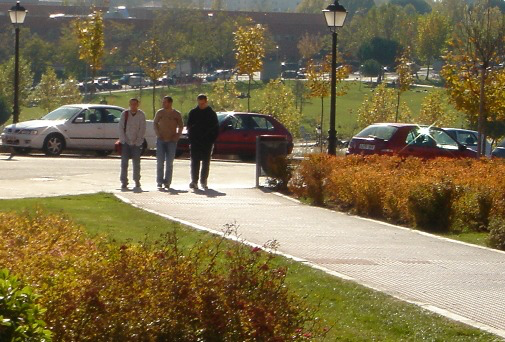

In [77]:
seed!(1234)
n_samples = size(data, 2)
random_perm = randperm(n_samples)
first_80_percent = Int(round(n_samples*0.8))
train_ind   = random_perm[1:first_80_percent]
test_ind    = random_perm[first_80_percent:end];
img = load("tutorial/humans.jpg")

In [95]:
n_classes  = 2
n_features = size(data, 1)
X_train    = data[:, train_ind];
y_train    = Int.(labels[train_ind] .+ 1)
percep     = MulticlassPerceptron.MulticlassPerceptronClassifier(Float32, n_classes, n_features)

MulticlassPerceptronClassifier{Float32}(n_classes=2, n_features=945)

In [79]:
n_features, n_samples

(945, 2674)

In [80]:
y_hat, score = MulticlassPerceptron.predict(percep, X_train[:,500])

(1, [259.177, 234.05])

In [87]:
y_hat_placeholder = zeros(2);
#y_hat, score = MulticlassPerceptron.predict(percep, X_train[:,500], y_hat_placeholder)

In [96]:
scores = []
MulticlassPerceptron.fit!(percep, X_train, y_train, n_epochs=100,  learning_rate=0.1, scores; print_flag=true)

In [143]:
function apply_model_every_patch(model, image, model_stride, patch_size, cell_stride, cell_size)
    y_scores = []
    y_hats = []
    positions = Dict()
    k = 0
    n_row_patch, n_col_patch = patch_size
    rows, cols = size(image)
    for j in 1:model_stride:(cols - n_col_patch)
        for i in 1:model_stride:(rows - n_row_patch)
            patch = view(image, i:i+n_row_patch-1, j:j+n_col_patch-1)                  
            descriptor = create_histmap_vec(patch, cell_stride, cell_size, n_bins); 
            y_hat, y_score  = predict(model, descriptor);
            push!(y_scores, y_score)
            push!(y_hats, y_hat)
            positions[k] = (i,j)
            k = k + 1
        end
    end
    return positions, y_hats, y_scores
end

apply_model_every_patch (generic function with 1 method)

In [145]:
img = load("tutorial/humans.jpg")
img = to_gray(img)
patch_size = size(pos_images[1])
positions, y_hats, y_scores = @time apply_model_every_patch(percep, img, stride, 
                                                            patch_size, cell_stride, cell_size);

  0.558315 seconds (384.41 k allocations: 250.678 MiB, 10.27% gc time)


In [146]:
patch_size, sum(y_hats.==2), stride

((128, 64), 13, 10)

In [156]:
pos = []
for (i,s) in enumerate(y_scores)
    if argmax(s).==2
        push!(pos, i)
    end
end
sum(map(argmax, y_scores).==1), sum(map(argmax, y_scores).==2)

(977, 13)

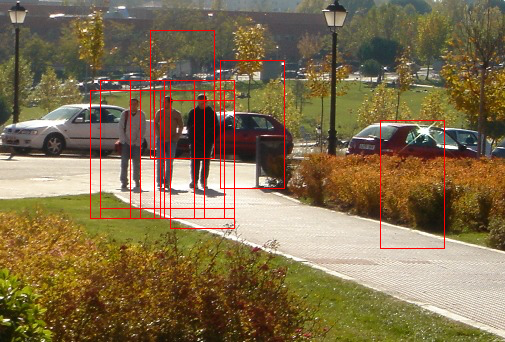

In [155]:
img = load("tutorial/humans.jpg")
pedestrians_detections = pos
imgres = deepcopy(img)
c = ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}}
for p in pedestrians_detections
    x,y = positions[p]
    imgres[x:x+n_row_patch,y]             .= c(1,0,0)      # Left vertical bar
    imgres[x:x+n_row_patch,y+n_col_patch] .= c(1,0,0)      # Right vertical bar
    imgres[x,y:y+n_col_patch]             .= c(1,0,0)      # Top horizontal bar
    imgres[x+n_row_patch,y:y+n_col_patch] .= c(1,0,0)      # Bottom horizontal bar
end
imgres

### TODO

Write `gradients_to_bins` as a `generated_function` in order to speed up the calls.
This will avoid

- Computing `upper_bin_limit += bin_width` at runtime (it willb e done at compile time)
- It should allocate 0 bytes when running


#### About number of times a percep.predict is applied

In [ ]:
n_row_image, n_col_image = size(image)
n_evaluations_per_row = ceil((n_row_image - patch_size[1])/10)
n_evaluations_per_col = ceil((n_col_image - patch_size[2])/10)
n_row_image, n_col_image = size(img)

In [ ]:
n_evaluations_per_row * n_evaluations_per_col

In [ ]:
println("number of evaluations of the model: ", length(positions))
println("size of the image: ", size(img))
println("patch size: ", patch_size)
println("stride: ", stride)

## Looping over the hogmap

In [157]:
image = load("tutorial/humans.jpg")
image_hogmap = create_histmap(image, cell_stride, cell_size, n_bins); 
println("size of the image: ", size(image))
println("size of the image_hogmap: ", size(image_hogmap))

size of the image: (342, 505)
size of the image_hogmap: (41, 62, 9)


In [158]:
patch  = negative_patches[1]
patch_hogmap = create_histmap(patch, cell_stride, cell_size, n_bins); 
println("patch size: ", patch_size)
println("size of the patch_hogmap: ", size(patch_hogmap))
println("number of elements patch_hogmap: ", length(patch_hogmap))

patch size: (128, 64)
size of the patch_hogmap: (15, 7, 9)
number of elements patch_hogmap: 945


In [159]:
# A window of (128,64) in the original image corresponds to a (30,14) window in the hogmap space 
length(patch_hogmap) == length(create_descriptor(patch,HOG()))

false

In [160]:
patch_hogmap_size =  size(patch_hogmap)[1:2]

(15, 7)

#### Correspondence of shapes: Original to Hogmap

- Notice that every cell `cell_size x cell_size` gets transformed to a single element  (of size `n_bins`) of the hogmap.
- The above prints suggest that a (128, 64) patch in the original image corresponds to a (30, 14) in the hogmap.
- Notice that the positions from the original image are mapped from the hogmap (THEY ARE PROBABLY WRONG, I HAVE NOT THOUGH A LOT ABOUT THE COORDINATES)

In [164]:
function apply_model_every_patch_hogmap(model, image, cell_stride, cell_size, n_bins, patch_hogmap_size, model_stride)
    y_scores = []
    y_hats = []
    positions = Dict()
    k = 0
    n_rows_patch_hogmap, n_cols_patch_hogmap = patch_hogmap_size   
    hogmap = create_histmap(image, cell_stride, cell_size, n_bins); 
    n_row, n_col, _ = size(hogmap)
    
    @inbounds for i in 1:model_stride:n_row - n_rows_patch_hogmap
        for j in 1:model_stride:n_col - n_cols_patch_hogmap
            descriptor = view(image_hogmap, i:i + n_rows_patch_hogmap-1, j:j + n_cols_patch_hogmap-1, :)
            descriptor = reshape(descriptor, length(descriptor))
            y_hat, y_score  = predict(model, descriptor);
            push!(y_scores, y_score)
            push!(y_hats, y_hat)
            positions[k] = ( i*cell_stride-cell_stride, j*cell_stride-cell_stride)
            k = k + 1
        end
    end
    return positions, y_hats, y_scores
end

apply_model_every_patch_hogmap (generic function with 1 method)

In [182]:
cell_stride = 8
cell_size   = 8
n_bins      = 9
model_stride = 2
image = load("tutorial/humans.jpg")
image = to_gray(image)
positions, y_hats, y_scores = apply_model_every_patch_hogmap(percep, image, cell_stride, cell_size, 
                                                             n_bins,  patch_hogmap_size, model_stride);

In [187]:
# It takes around 0.02 sec to detect the pedestrians
@time  apply_model_every_patch_hogmap(percep, image, cell_stride, cell_size, 
                                           n_bins,  patch_hogmap_size, model_stride);



  0.021474 seconds (14.87 k allocations: 5.596 MiB)


In [166]:
# This is 20 fps and without multiprocessing!
@benchmark  apply_model_every_patch_hogmap(percep, image, cell_stride, cell_size, 
                                           n_bins,  patch_hogmap_size, model_stride)


BenchmarkTools.Trial: 
  memory estimate:  5.60 MiB
  allocs estimate:  14865
  --------------
  minimum time:     14.988 ms (0.00% GC)
  median time:      17.884 ms (0.00% GC)
  mean time:        18.067 ms (0.00% GC)
  maximum time:     22.645 ms (0.00% GC)
  --------------
  samples:          277
  evals/sample:     1

In [171]:
println("frames per second: ", 1000/18)

frames per second: 55.55555555555556


In [172]:
patch_size, sum(y_hats.==2), stride

((128, 64), 4, 10)

In [174]:
pos = []
for (i,s) in enumerate(y_scores)
    if argmax(s).==2
        push!(pos, i)
    end
end

In [175]:
sum(map(argmax, y_scores).==1), sum(map(argmax, y_scores).==2)

(360, 4)

In [177]:
sort([y[2]/y[1] for y in y_scores]);

In [178]:
n_row_patch, n_col_patch = patch_size

(128, 64)

In [180]:
pedestrians_detections = pos
imgres = deepcopy(img)
c = ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}}
for p in pedestrians_detections
    x,y = positions[p]
    imgres[x:x+n_row_patch,y]             .= c(1,0,0)      # Left vertical bar
    imgres[x:x+n_row_patch,y+n_col_patch] .= c(1,0,0)      # Right vertical bar
    imgres[x,y:y+n_col_patch]             .= c(1,0,0)      # Top horizontal bar
    imgres[x+n_row_patch,y:y+n_col_patch] .= c(1,0,0)      # Bottom horizontal bar
end

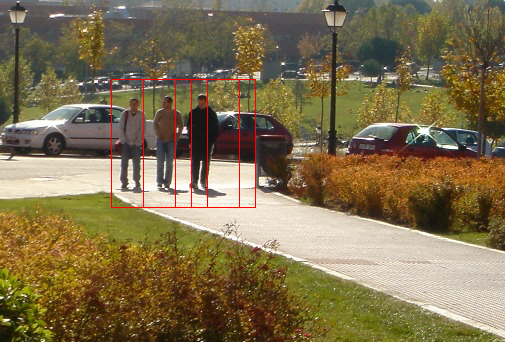

In [181]:
imgres

### Visuallize hogmap

In [ ]:
image_gray = to_gray(image);

In [ ]:
hogmap = create_histmap(image, cell_stride, cell_size, n_bins); 

In [ ]:
imshow(hogmap[:,:,5])

In [ ]:
imshow(hogmap[:,:,2])

In [ ]:
imshow(mean(hogmap,3)[:,:,1])

In [ ]:
imshow(max(hogmap,3)[:,:,1])

### Parallelizing parts of the code

In [ ]:
using Base.Threads
@show nthreads()

In [ ]:
function apply_model_every_patch_hogmap(model, image, cell_stride, cell_size, n_bins, patch_hogmap_size, model_stride)
    #y_scores = []
    #y_hats = []
    positions = Dict()
    y_scores  = Dict()
    y_hats     = Dict()
    k = 0
    n_rows_patch_hogmap, n_cols_patch_hogmap = patch_hogmap_size   
    hogmap = create_histmap(image, cell_stride, cell_size, n_bins); 
    n_row, n_col, _ = size(hogmap)
    
    @inbounds for i in 1:model_stride:n_row - n_rows_patch_hogmap
         for j in 1:model_stride:n_col - n_cols_patch_hogmap
            descriptor = view(image_hogmap, i:i + n_rows_patch_hogmap-1, j:j + n_cols_patch_hogmap-1, :)
            descriptor = reshape(descriptor, length(descriptor))
            y_hat, y_score  = Perceptron.predict(model, descriptor);
            #push!(y_scores, y_score)
            #push!(y_hats, y_hat)
            y_scores[i,j] = y_score
            y_hats[i,j]    = y_hat
            positions[i,j] = ( i*cell_stride-cell_stride, j*cell_stride-cell_stride)
            #k = k + 1
        end
    end
    return positions, y_hats, y_scores
end

In [ ]:
aux = Dict()
aux[2,3] = 23

In [ ]:
cell_stride = 8
cell_size   = 8
n_bins      = 9
model_stride = 2
image = load("tutorial/humans.jpg")
positions, y_hats, y_scores = apply_model_every_patch_hogmap(percep, image, cell_stride, cell_size, 
                                                             n_bins,  patch_hogmap_size, model_stride);

In [ ]:
# This is 20 fps and without multiprocessing!
# Error thrown in threaded loop on thread 2: UndefRefError
@time  apply_model_every_patch_hogmap(percep, image, cell_stride, cell_size, 
                                                            n_bins,  patch_hogmap_size, model_stride);

In [ ]:
@benchmark  apply_model_every_patch_hogmap(percep, image, cell_stride, cell_size, 
                                           n_bins,  patch_hogmap_size, model_stride)

In [ ]:
25.072 * 40

In [ ]:
p = Profile.@profile apply_model_every_patch_hogmap(percep, image, cell_stride, cell_size, 
                                           n_bins,  patch_hogmap_size, model_stride)

In [ ]:
#?@profile